In [1]:
NORMAL_DRIVING_PATH = './data2/normal/'
CORRECTIN_DRIVING_PATH = './data2/correcting/'
REVERSE_DRIVING_PATH = './data2/reverse/'

In [2]:
import csv
import cv2
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

def get_lines(path):
    lines = []
    with open ('%sdriving_log.csv' % path) as csvfile:
        reader = csv.reader(csvfile)
        for line in reader:
            lines.append(line)
        return lines


normal_lines = get_lines(NORMAL_DRIVING_PATH)
correction_lines = get_lines(CORRECTIN_DRIVING_PATH)
reverse_lines = get_lines(REVERSE_DRIVING_PATH)
print(normal_lines[0][0].split('/')[-1])
print(correction_lines[0][0].split('/')[-1])
print(reverse_lines[0][0].split('/')[-1])



center_2017_10_24_17_22_37_747.jpg
center_2017_10_24_17_35_52_913.jpg
center_2017_10_24_17_27_05_890.jpg


In [3]:
def load_image(img_full_path):
    # Name of the img, e.g. center_2017_10_24_17_22_37_747.jpg
    name = img_full_path.split('/')[-1]

    # Mode, i.e. normal, correcting, reverse
    dataset = img_full_path.split('/')[-3]

    path = './data2/%s/IMG/%s' % (dataset, name)
    img = cv2.imread(path, cv2.IMREAD_COLOR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img
    

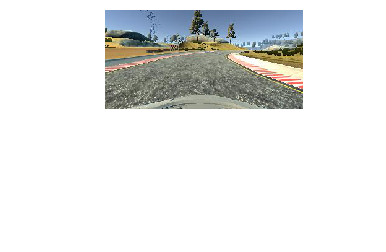

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

sample_img = load_image(reverse_lines[0][0])

fig, ax = plt.subplots(nrows=2)
ax = ax.ravel()
ax[0].imshow(sample_img)

for a in ax:
    a.axis('off')

In [45]:
import numpy as np
from skimage import transform

def random_translate(img, steering_angle, is_debug=False):
    random_x = np.random.randint(-50, 50)
    random_y = np.random.randint(-25, 25)
    steering_angle = steering_angle + random_x * 0.004
    tform = transform.SimilarityTransform(translation=(random_x, random_y))
    translated = transform.warp(img, tform)
    if is_debug:
        print('Random X: %s, Random Y: %s, Steering Angle Adjustment: %s' %(random_x, random_y, steering_angle))
    return translated, steering_angle

Random X: 45, Random Y: -24, Steering Angle Adjustment: 0.18
Random X: 13, Random Y: -3, Steering Angle Adjustment: 0.052000000000000005
Random X: 5, Random Y: -9, Steering Angle Adjustment: 0.02
Random X: -35, Random Y: -5, Steering Angle Adjustment: -0.14
Random X: -3, Random Y: 8, Steering Angle Adjustment: -0.012
Random X: -44, Random Y: 13, Steering Angle Adjustment: -0.176
Random X: -15, Random Y: -13, Steering Angle Adjustment: -0.06
Random X: -49, Random Y: -10, Steering Angle Adjustment: -0.196
Random X: -36, Random Y: 10, Steering Angle Adjustment: -0.14400000000000002
Random X: -26, Random Y: 14, Steering Angle Adjustment: -0.10400000000000001
Random X: -20, Random Y: -11, Steering Angle Adjustment: -0.08
Random X: 0, Random Y: 10, Steering Angle Adjustment: 0.0
Random X: 40, Random Y: -17, Steering Angle Adjustment: 0.16
Random X: 32, Random Y: 6, Steering Angle Adjustment: 0.128
Random X: 26, Random Y: 9, Steering Angle Adjustment: 0.10400000000000001
Random X: -40, Random

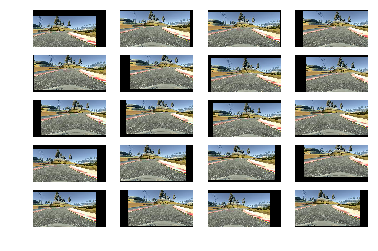

In [46]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import transform
%matplotlib inline


sample_img = load_image(reverse_lines[0][0])
steering_angle = 0
fig, ax = plt.subplots(nrows=5, ncols=4)

ax = ax.ravel()

for i in range(0, 20):
    translated, _ = random_translate(sample_img, steering_angle, is_debug=True)
    ax[i].imshow(translated)

for a in ax:
    a.axis('off')

In [47]:
import sklearn.utils

CENTER = 0
LEFT = 1
RIGHT = 2
ANGLE = 3
LEFT_ANGLE_CORRECTION = 0.2
RIGHT_ANGLE_CORRECTION = -0.2

def generator(data, batch_size=128):
    num_samples = len(data)
    while True:
        data = sklearn.utils.shuffle(data)
        for offset in range(0, num_samples, batch_size):
            batch_samples = data[offset:offset+batch_size]
            
            images = []
            angles = []
            for batch_sample in batch_samples:
                center_img = load_image(batch_sample[CENTER])
                left_img = load_image(batch_sample[LEFT])
                right_img = load_image(batch_sample[RIGHT])
                angle = float(batch_sample[ANGLE])
                
                images.append(center_img)
                angles.append(angle)
                images.append(cv2.flip(center_img, 1))
                angles.append(angle * -1)
                
                translated_center_img, translated_center_angle = random_translate(center_img, angle)
                images.append(translated_center_img)
                angles.append(translated_center_angle)
                
                images.append(left_img)
                angles.append(angle + LEFT_ANGLE_CORRECTION)
                #images.append(cv2.flip(left_img, 1))
                #angles.append((angle + LEFT_ANGLE_CORRECTION) * -1)
                
                images.append(right_img)
                angles.append(angle + RIGHT_ANGLE_CORRECTION)
                #images.append(cv2.flip(right_img, 1))
                #angles.append((angle + RIGHT_ANGLE_CORRECTION) * -1)
            
            x_images = np.array(images)
            y_labels = np.array(angles)
            yield sklearn.utils.shuffle(x_images, y_labels)
        

In [48]:
from sklearn.model_selection import train_test_split

# Combine all the data lines together.
all_lines = normal_lines + correction_lines + reverse_lines

train_samples, validation_samples = train_test_split(all_lines, test_size=0.2)
train_generator = generator(train_samples, batch_size=256)
validation_generator = generator(validation_samples, batch_size=256)

In [49]:
def resize(img):
    import tensorflow as tf
    return tf.image.resize_images(img, (66, 200))

In [50]:
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten, Reshape, SpatialDropout2D
from keras.layers.convolutional import Convolution2D
from keras.layers import Cropping2D, Lambda, Reshape, Dropout

model = Sequential()
# Shave 50px from the top and 20px from the bottom to be left with a 90x320x img
#model.add(Cropping2D(cropping=((50, 20), (0, 0)), input_shape=(160, 320, 3)))

# Resize the image to match the nvidia sizes.
model.add(Lambda(resize, input_shape=(160, 320, 3)))

# Normalize the image.
model.add(Lambda(lambda x: x/255.0 - 0.5))
model.add(Convolution2D(24, 5, 5, subsample=(2, 2), name='conv1', activation='elu'))
model.add(Convolution2D(36, 5, 5, subsample=(2, 2), name='conv2', activation='elu'))
model.add(Convolution2D(48, 5, 5, subsample=(2, 2), name='conv3', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv4', activation='elu'))
model.add(SpatialDropout2D(0.5))
model.add(Convolution2D(64, 3, 3, name='conv5', activation='elu'))

model.add(Flatten())
#model.add(Dense(1, activation='elu'))

model.summary()

model.add(Dense(1164, name='desn1164', activation='elu'))
model.add(Dropout(0.5))
model.add(Dense(100, name='dense100'))
model.add(Dropout(0.5))
model.add(Dense(50, name='dense50'))
model.add(Dropout(0.5))
model.add(Dense(10, name='dense10'))
model.add(Dense(1, name='dense1'))

model.compile(loss='mse', optimizer='adam')
model.fit_generator(
    train_generator,
    samples_per_epoch=len(train_samples * 5),    # * 6 for center, left, and right image
    validation_data=validation_generator,
    nb_val_samples=len(validation_samples * 5),  # * 6 for center, left, and right image
    nb_epoch=10)

model.save('model.h5')

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
lambda_5 (Lambda)                (None, 66, 200, 3)    0           lambda_input_3[0][0]             
____________________________________________________________________________________________________
lambda_6 (Lambda)                (None, 66, 200, 3)    0           lambda_5[0][0]                   
____________________________________________________________________________________________________
conv1 (Convolution2D)            (None, 31, 98, 24)    1824        lambda_6[0][0]                   
____________________________________________________________________________________________________
conv2 (Convolution2D)            (None, 14, 47, 36)    21636       conv1[0][0]                      
___________________________________________________________________________________________

Exception in thread Thread-10:
Traceback (most recent call last):
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 914, in _bootstrap_inner
    self.run()
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/threading.py", line 862, in run
    self._target(*self._args, **self._kwargs)
  File "/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/keras/engine/training.py", line 429, in data_generator_task
    generator_output = next(self._generator)
  File "<ipython-input-47-eb4231cca7a3>", line 44, in generator
    x_images = np.array(images)
MemoryError



ValueError: output of generator should be a tuple (x, y, sample_weight) or (x, y). Found: None